# PeruSat-1: Entrenamiento

En este notebook se describen los pasos para entrenar un modelo de U-Net para escenas de PeruSat-1.

En particular, se muestra como entrenar el modelo **v6**, cuyo conjunto de datos consiste en:
* Escena de Carabayllo, fecha 2020-05-09
* Escena de MangoMarca, fecha 2020-04-22
* Escena del sur (?), fecha ?

Las clases a identificar son:
* C: Caminos
* D: Suelo disturbado
* U: Urbano
* V: Vegetación
* N: Otros ("negativo")

La clase `N` es especial dado que es eliminada de los resultados de clasificación en una tarea de postprocesamiento.

In [1]:
from satlomasproc.unet.train import TrainConfig, train
from satlomasproc.unet.predict import PredictConfig, predict
from satlomasproc.unet.evaluate import plot_data_generator
import os

/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-pack

Se asume que todos los archivos se almacenan en `~/data/lomas/ps1/`, pero se puede ajustar cambiando la siguiente variable.

In [2]:
BASE_DIR = os.path.join(os.path.expanduser('~'), 'data', 'lomas', 'ps1')

## Sobre U-Net y el conjunto de datos de entrada

U-Net es una arquitectura de red neuronal de *segmentación semántica*. En particular, para cada clase definida, se calcula la probabilidad de que cada pixel de la imagen pertenezca a una clase. Luego en un paso de post-procesamiento, se elige la clase de mayor probabilidad, obteniendo así una imagen de cobertura de suelo, donde cada pixel tiene un valor que representa la clase a la que pertenece (1 = "clase 1", 2 = "clase 2", etc.)

Generalmente las redes neuronales trabajan con imagenes de tamaño fijo, y en el campo del sensado remoto, una práctica habitual es generar teselas (*tiles*) o chips de las imágenes geoespaciales, recorriéndolas en una grilla y extrayendo cada chip en un archivo separado. Este proceso se puede realizar con la herramienta `satlomasproc_extract_chips`, incluida en el paquete de `satlomasproc`. A continuación se demuestra como realizar estos procesos para generar un conjunto de datos para el entrenamiento.

## Anotaciones

Además de adquirir las imágenes satelitales, se debe preparar un archivo vectorial de polígonos, donde cada *feature* representa un ejemplo del objeto o área de cobertura de cada clase que se desee identificar.

Cada feature debe tener una columna llamada `class` de tipo *string*, que indique las clases definidas previamente.

## Extracción de chips y generación de máscaras

Antes de extraer los chips, se deben preparar las imágenes de PeruSat-1 a utilizar.

En este ejemplo, las escenas de PeruSat-1 fueron preprocesadas a una imagen RGB *pansharpened* con `perusatproc`. Luego se escalaron como imágenes RGB entre 0 y 255 (esto se puede realizar con QGIS, exportando la capa raster en modo "Rendered").

Una vez que se tienen las imágenes RGB y el shapefile de anotaciones, se puede generar los chips (imágenes cuadradas) de 320x320 píxeles, sobre las áreas donde se anotaron con polígonos (definidos sobre el archivo vectorial AOI) utilizando la herramienta `satlomasproc_extract_chips`.

Ejemplo:

```bash
satlomasproc_extract_chips \
    -v --size 320 --step-size 160 \
    -o $BASE_DIR/train/320_160/ \
    --bands 1 2 3 \
    --classes C D N U V \
    --labels $BASE_DIR/train/raw/labels.shp \
    --aoi $BASE_DIR/train/raw/labels.shp \
    --write-geojson \
    $BASE_DIR/train/raw/CARABAYLLO_20200509_clip_rgb.tif \
    $BASE_DIR/train/raw/MANGOMARCA_20200422_clip_rgb.tif \
    $BASE_DIR/train/raw/CICASOS_20200422_clip_rgb.tif
```

Notar que:
* Las imágenes están en `$BASE_DIR/train/raw/` y se llaman `CARABAYLLO_20200509_clip_rgb.tif` y `MANGOMARCA_20200422_clip_rgb.tif` respectivamente.
* El archivo vectorial con las anotaciones está en `$BASE_DIR/train/raw/labels.shp`.
* `--size` 320 y `--step-size 160` indican que se generarán chips de 320x320, con solapamiento cada 160 píxeles. Al entrenar es preferible generar chips con solapamiento, porque nos da mayor cantidad de imágenes de entrada y mejora el rendimiento del modelo.
* `--aoi` indica un shapefile con el área de interés. Esta opción hace que se generen chips que intersecan con los polígonos de este shapefile. En este caso, utilizamos nuevamente el shapefile de anotaciones, porque sólo queremos entrenar con chips que contengan áreas a detectar y no sólo *background*.
* `--write-geojson` se asegura de que se genere un GeoJSON con polígonos de los chips extraidos, es decir, la grilla que recorre el proceso. Esto será útil en el siguiente paso (opcional, pero recomendado).

Al finalizar el proceso, deberían haberse creado dos directorios en `$BASE_DIR/train/320_160`:
* `images/` contiene GeoTiffs de los chips RGB de 320x320
* `masks/` contiene GeoTiffs con las máscaras, donde cada banda es la máscara de cada clase en el orden definido con `--classes`.

## Mejorar anotaciones y volver a extraer chips

Para obtener mejores resultados al entrenar, recomendamos hacer una segunda iteración de anotaciones, esta vez cargando el GeoJSON de la grilla que `extract_chips` generó en el paso anterior, y anotar de manera completa de chip que luego será extraido.

Es muy importante que cada chip sea **anotado por completo**, es decir, si dentro de un chip de la grilla hay elementos o áreas que deberían ser anotadas con alguna clase, no hay que omitirlas. De lo contrario, el modelo podría llegar a aprender que esas áreas *no son* de esa clase, y confundirse luego.

Cuando se tenga un mejor shapefile de anotaciones, volver a correr el comando anterior.

## Entrenamiento

Ahora que tenemos el conjunto de datos preparado para entrenar, pasamos al paso de entrenamiento. Primero construimos la configuración de entrenamiento con las siguientes variables:

* `width` y `height`: Tamaño de los chips, que como mencionamos en el paso anterior, es de 320x320
* `n_channels`: Cantidad de bandas de los chips, como son RGB, es 3
* `n_classes`: Cantidad de clases. En este caso las anotaciones tienen 5 clases.
* `epochs`: Cantidad de epochs máxima para entrenar.
* `batch_size`: Tamaño de cada lote de entrenamiento. Para una computadora con GPU 32 es apropiado, pero si se tienen menos recursos, es necesario disminuir este valor
* `steps_per_epoch`: Cantidad de pasos en cada epochs
* `early_stopping_patience`: Cuantos epochs deben pasar sin ver mejoras para detener el entrenamiento. Esto es útil para evitar el sobreajuste.
* `validation_split`: Representa la proporción del conjunto de validación en cada epoch. Es un número entre 0 y 1. Por ej, 0.1 quiere decir que el 10% del total de imagenes se usarán para validar y no entrenar.
* `images_path`: La ruta al directorio con los chips (debería ser el directorio de salida del `extract_chips`)
* `model_path`: La ruta donde se guardará el modelo entrenado al finalizar el entrenamiento.

In [3]:
config = TrainConfig(width=320,
                     height=320,
                     n_channels=3,
                     n_classes=5,
                     apply_image_augmentation=True,
                     seed=42,
                     epochs=50, # 50
                     batch_size=32,
                     steps_per_epoch=100, # 500
                     early_stopping_patience=10,
                     validation_split=0.1,
                     evaluate=False,
                     images_path=os.path.join(BASE_DIR, 'train', '320_160'),
                     model_path=os.path.join(BASE_DIR, 'weights', 'lomas_ps1_v6.h5'))

Podemos plotear una muestra de imágenes y sus máscaras por clase con la función `plot_data_generator`, para verificar que todo está en orden.

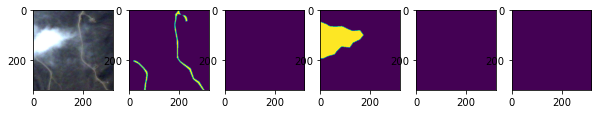

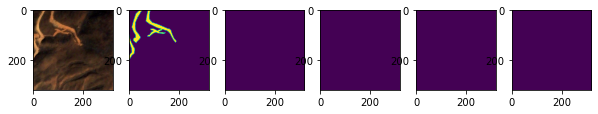

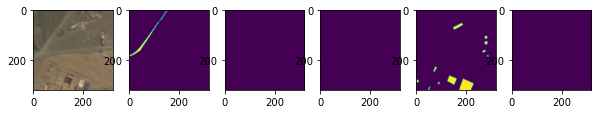

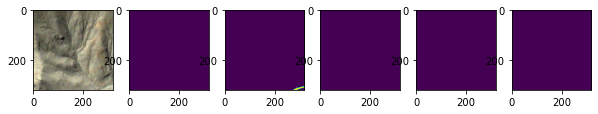

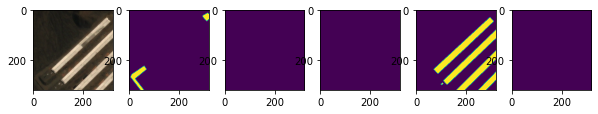

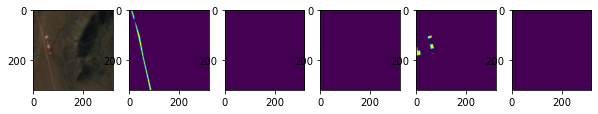

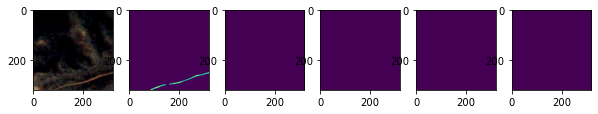

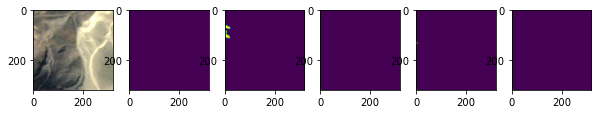

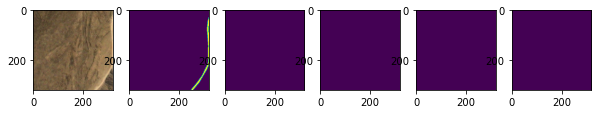

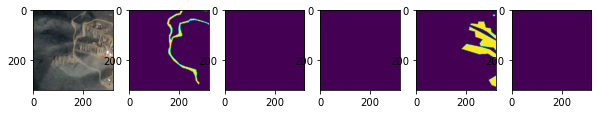

In [4]:
plot_data_generator(train_config=config, num_samples=10, fig_size=(10,6))

Comenzamos el proceso de entrenamiento con la función `train`, pasándole la configuración antes creada.

In [5]:
results = train(config)


Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        conv2d_1[0][0]                   
_________________________________________________________________


Epoch 1/50
100/100 [==============================] - 244s 2s/step - loss: 0.5809 - accuracy: 0.2040 - mean_iou: 0.4800 - val_loss: 0.2879 - val_accuracy: 0.1257 - val_mean_iou: 0.5034

Epoch 00001: val_loss improved from inf to 0.28790, saving model to /home/ro/data/lomas/ps1/weights/lomas_ps1_v6.h5
Epoch 2/50
100/100 [==============================] - 216s 2s/step - loss: 0.2519 - accuracy: 0.1709 - mean_iou: 0.5062 - val_loss: 0.2159 - val_accuracy: 0.1078 - val_mean_iou: 0.5056

Epoch 00002: val_loss improved from 0.28790 to 0.21588, saving model to /home/ro/data/lomas/ps1/weights/lomas_ps1_v6.h5
Epoch 3/50
100/100 [==============================] - 226s 2s/step - loss: 0.2362 - accuracy: 0.1609 - mean_iou: 0.5058 - val_loss: 0.2356 - val_accuracy: 0.1460 - val_mean_iou: 0.5059

Epoch 00003: val_loss did not improve from 0.21588
Epoch 4/50
100/100 [==============================] - 228s 2s/step - loss: 0.2289 - accuracy: 0.1947 - mean_iou: 0.5060 - val_loss: 0.2578 - val_accuracy:


Epoch 00032: val_loss improved from 0.14246 to 0.12521, saving model to /home/ro/data/lomas/ps1/weights/lomas_ps1_v6.h5
Epoch 33/50
100/100 [==============================] - 227s 2s/step - loss: 0.1576 - accuracy: 0.3121 - mean_iou: 0.5325 - val_loss: 0.1312 - val_accuracy: 0.2669 - val_mean_iou: 0.5329

Epoch 00033: val_loss did not improve from 0.12521
Epoch 34/50
100/100 [==============================] - 230s 2s/step - loss: 0.1593 - accuracy: 0.3075 - mean_iou: 0.5335 - val_loss: 0.1459 - val_accuracy: 0.2350 - val_mean_iou: 0.5340

Epoch 00034: val_loss did not improve from 0.12521
Epoch 35/50
100/100 [==============================] - 227s 2s/step - loss: 0.1514 - accuracy: 0.2615 - mean_iou: 0.5345 - val_loss: 0.2123 - val_accuracy: 0.3925 - val_mean_iou: 0.5349

Epoch 00035: val_loss did not improve from 0.12521
Epoch 36/50
100/100 [==============================] - 228s 2s/step - loss: 0.1592 - accuracy: 0.2953 - mean_iou: 0.5354 - val_loss: 0.2154 - val_accuracy: 0.4966 - 

Dado que los resultados del entrenamiento los tenemos en la variable `results`, podemos plotear las métricas de la función de pérdida (*loss*) y la métrica *IoU* (*intersection over union*), entre el conjunto de entrenamiento (*train*) y validación (*val*).

Lo importante a la hora de decidir si hay sobreajuste es que la pérdida (loss) de entrenamiento no baje demasiado de la de validación.

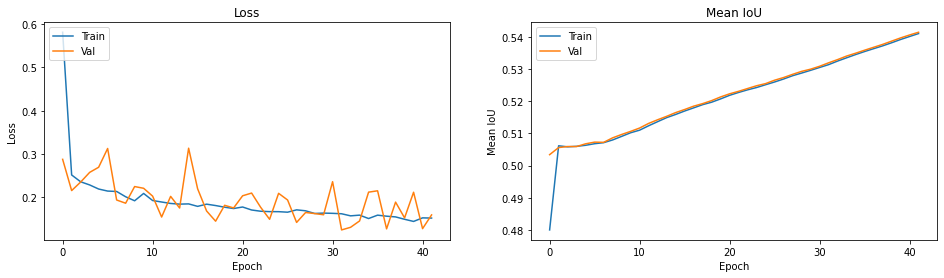

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

Al finalizar el entrenamiento, debería haberse generado un archivo con los pesos de la red neuronal en `$BASE_DIR/weights/lomas_ps1_v5.h5`. Este archivo lo necesitaremos para futuras predicciones.

In [8]:
config_b = TrainConfig(width=320,
                     height=320,
                     n_channels=3,
                     n_classes=5,
                     apply_image_augmentation=True,
                     seed=42,
                     epochs=50, # 50
                     batch_size=32,
                     steps_per_epoch=500,
                     early_stopping_patience=10,
                     validation_split=0.1,
                     evaluate=False,
                     images_path=os.path.join(BASE_DIR, 'train', '320_160'),
                     model_path=os.path.join(BASE_DIR, 'weights', 'lomas_ps1_v6b.h5'))

In [9]:
results_b = train(config)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 320, 320, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 320, 320, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

Epoch 1/50
500/500 [==============================] - 1147s 2s/step - loss: 0.2605 - accuracy: 0.1801 - mean_iou: 0.4978 - val_loss: 0.2189 - val_accuracy: 0.1077 - val_mean_iou: 0.5026

Epoch 00001: val_loss improved from inf to 0.21890, saving model to /home/ro/data/lomas/ps1/weights/lomas_ps1_v6b.h5
Epoch 2/50
500/500 [==============================] - 1143s 2s/step - loss: 0.2056 - accuracy: 0.2163 - mean_iou: 0.5066 - val_loss: 0.2376 - val_accuracy: 0.5482 - val_mean_iou: 0.5104

Epoch 00002: val_loss did not improve from 0.21890
Epoch 3/50
500/500 [==============================] - 1153s 2s/step - loss: 0.1960 - accuracy: 0.2496 - mean_iou: 0.5139 - val_loss: 0.1991 - val_accuracy: 0.2318 - val_mean_iou: 0.5171

Epoch 00003: val_loss improved from 0.21890 to 0.19905, saving model to /home/ro/data/lomas/ps1/weights/lomas_ps1_v6b.h5
Epoch 4/50
500/500 [==============================] - 1166s 2s/step - loss: 0.1845 - accuracy: 0.2680 - mean_iou: 0.5202 - val_loss: 0.1843 - val_accu

500/500 [==============================] - 1149s 2s/step - loss: 0.0904 - accuracy: 0.4669 - mean_iou: 0.6314 - val_loss: 0.0926 - val_accuracy: 0.5245 - val_mean_iou: 0.6330

Epoch 00033: val_loss did not improve from 0.05759
Epoch 34/50
500/500 [==============================] - 1079s 2s/step - loss: 0.0876 - accuracy: 0.4554 - mean_iou: 0.6345 - val_loss: 0.0821 - val_accuracy: 0.6207 - val_mean_iou: 0.6360

Epoch 00034: val_loss did not improve from 0.05759
Epoch 35/50
500/500 [==============================] - 1073s 2s/step - loss: 0.0868 - accuracy: 0.4823 - mean_iou: 0.6375 - val_loss: 0.1078 - val_accuracy: 0.6550 - val_mean_iou: 0.6389

Epoch 00035: val_loss did not improve from 0.05759
Epoch 36/50
500/500 [==============================] - 1180s 2s/step - loss: 0.0845 - accuracy: 0.5208 - mean_iou: 0.6405 - val_loss: 0.1565 - val_accuracy: 0.3091 - val_mean_iou: 0.6418

Epoch 00036: val_loss did not improve from 0.05759
Epoch 37/50
500/500 [==============================] - 1

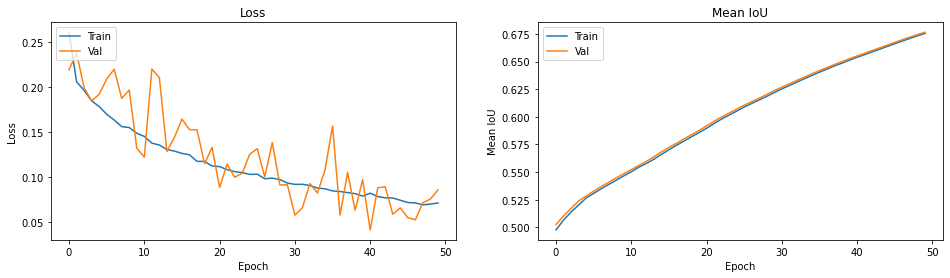

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(results_b.history['loss'])
plt.plot(results_b.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(results_b.history['mean_iou'])
plt.plot(results_b.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()